In [1]:
import sys, os
sys.path.insert(0, os.getcwd()+'/..')

import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from PIL import Image
import caffe
from DataLoader import load_cifar
%matplotlib inline

caffe.set_mode_gpu()
caffe.set_device(0)

load_cifar(datapath = '../Data')
print 'ok'

ok


In [ ]:
import caffe
from caffe import layers as L
from caffe import params as P


def cnn(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    n.conv1 = L.Convolution(n.data, kernel_size=4, num_output=64, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.cccp1b, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.relu1b, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.drop2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.relu3, num_output=768, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    return n.to_proto()
    

def lenet(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=48, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.relu1a, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    #n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.drop1, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    #n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    #n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.pool3, num_output=350, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    #n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    #n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    #n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    
    return n.to_proto()

    
with open('cnn_train.prototxt', 'w') as f:
    f.write(str(cnn('train.txt', 128)))
    
with open('cnn_test.prototxt', 'w') as f:
    f.write(str(cnn('test.txt', 128)))

solver = caffe.get_solver('cnn_solver_rms.prototxt')

print("Layers' features:")
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

In [ ]:
print("Parameters and shape:")
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

In [ ]:
!cat cnn_solver_rms.prototxt

In [22]:
from subprocess import call
def change_solver(optimizer='RMSProp', max_iter = 100):
    global solver
    call(
'''echo "train_net: 'cnn_train.prototxt'
test_net: 'cnn_test.prototxt'

test_iter: 0
test_interval: {1}0

base_lr: 0.0006
momentum: 0.0
weight_decay: 0.001

lr_policy: 'inv'
gamma: 0.0001
power: 0.75

display: 0

max_iter: {1}

snapshot: {2}
snapshot_prefix: 'snapshots/cnn_snapshot'
solver_mode: GPU

type: '{0}'
rms_decay: 0.98" > new_solver.prototxt'''.format(optimizer, max_iter, max_iter-1),
            shell=True
        )
    solver = caffe.get_solver('new_solver.prototxt')
#base_lr: 0.01
#momentum: 0.9
#weight_decay: 0.0005

In [ ]:
#%%time
#!$CAFFE_ROOT/build/tools/caffe train -solver cnn_solver_rms.prototxt

In [ ]:
#%%time
#!$CAFFE_ROOT/build/tools/caffe test -model cnn_test.prototxt -weights cnn_snapshot_iter_10000.caffemodel -iterations 10

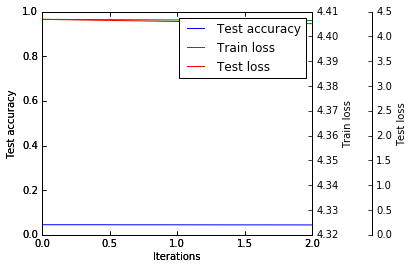

In [39]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

def plot_accuracy_loss(train_loss, test_loss, test_acc, solution_id, test_interval):  
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 60
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par2.axis["right"].toggle(all=True)

    host.set_xlim(0, 2)
    host.set_ylim(0, 2)

    host.set_xlabel("Iterations")
    host.set_ylabel("Test accuracy")
    par1.set_ylabel("Train loss")
    par2.set_ylabel("Test loss")
    xs = np.array(range(len(test_acc)))*test_interval
    p1, = host.plot(xs, test_acc, label="Test accuracy")
    p2, = par1.plot(xs, train_loss, label="Train loss")
    p3, = par2.plot(xs, test_loss, label="Test loss")
    
    host.set_ylim(0,1)
    #par1.set_ylim(0, 4)
    #par2.set_ylim(1, 65)

    host.legend()

    host.axis["right"].label.set_color(p1.get_color())
    par1.axis["left"].label.set_color(p2.get_color())
    par2.axis["left"].label.set_color(p3.get_color())

    plt.draw()
    plt.show()
    plt.savefig("figures/{}".format(solution_id))


def run_solver():
    solution_id = randint(1,100000)
    niter = 300
    test_interval = 100
    output_len = int(np.ceil(niter * 1.0 / test_interval))

    train_loss = np.zeros(output_len)
    test_loss = np.zeros(output_len)
    test_acc = np.zeros(output_len)

    for it in range(output_len):
        solver.step(test_interval)
        train_loss[it] = solver.net.blobs['loss_f'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        solver.test_nets[0].forward(start='conv1')

        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip_f'].data.argmax(axis=1)
                           == solver.test_nets[0].blobs['label_fine'].data)
        test_acc[it / test_interval] = correct / 1e4
        test_loss[it / test_interval] = solver.test_nets[0].blobs['loss_f'].data
    plot_accuracy_loss(train_loss, test_loss, test_acc, solution_id, test_interval)    
    return train_loss, test_loss, test_acc, solution_id, test_interval

In [23]:
change_solver(optimizer='RMSProp', max_iter = 10000)
run_solver()

In [18]:
test_acc.shape[0]

3

In [10]:
train_loss.shape

(300,)